## First generate an image with Flux Schnell

In [1]:
import torch
from diffusers import FluxPipeline
from diffusers.utils import load_image
from torchvision import transforms
from PIL import Image
import numpy as np
import cv2
from utils import preprocess_image,pil_to_cv2,cv2_to_pil, show_image_cv2, clear_gpu_memory,run_with_conda_env
import copy
from diffusion_utils import load_pipeline,generate_outpaint,fix_mask, fix_inpaint_mask, vis_inpaint_strategy,composite_with_mask, load_contolnet_pipeline,outpaint_controlnet
import torch
from dust3r_infer import get_focals
from image_utils import *
import copy

GEN = False
USE_SDXL = False

IMAGE_SIZE = 1024
if GEN == True:
	pipe = FluxPipeline.from_pretrained("black-forest-labs/FLUX.1-schnell", torch_dtype=torch.bfloat16)
	pipe.enable_model_cpu_offload() #save some VRAM by offloading the model to CPU. Remove this if you have enough GPU power
	prompt = "a town square in a city with a person standing in the center"
	image = pipe(
		prompt,
		guidance_scale=0.0,
		num_inference_steps=4,
		max_sequence_length=256,
		generator=torch.Generator("cpu").manual_seed(0)
	).images[0]
	image.save("middle.jpg")
	clear_gpu_memory()
	focals = get_focals('middle.jpg', 512)
	source_image_cv2 = pil_to_cv2(image)
	show_image_cv2(source_image_cv2)



Warning, cannot find cuda-compiled version of RoPE2D, using a slow pytorch version instead


/home/cedric/PanoramaGenInpaint/dust3r/dust3r/cloud_opt/base_opt.py:275: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  @torch.cuda.amp.autocast(enabled=False)


## Use Dust3R to estimate the FOV and map it to the equirectangular image

In [2]:
if GEN and DUST3R : 
	h_fov = focal_to_fov(focals[0], 512)  # Assuming 512 is your reference dimension
	print(f"Horizontal FOV: {h_fov} degrees")
	equirectangular_image,non_wrapped = image_to_equirectangular(source_image_cv2, h_fov, 2028*4,1024*4,wrap_around=True)
	cv2_to_pil(equirectangular_image).save("imgs/initial_pano_with_back.png")
	cv2_to_pil(non_wrapped).save("imgs/initial_pano_center.png")
	show_image_cv2(equirectangular_image)

## Visualisation of rough inpainting regions

/home/cedric/PanoramaGenInpaint/image_utils.py:362: RuntimeWarning: divide by zero encountered in divide
  persp_ndc_x = world_x / world_z
/home/cedric/PanoramaGenInpaint/image_utils.py:363: RuntimeWarning: divide by zero encountered in divide
  persp_ndc_y = world_y / world_z
/home/cedric/PanoramaGenInpaint/image_utils.py:363: RuntimeWarning: invalid value encountered in divide
  persp_ndc_y = world_y / world_z


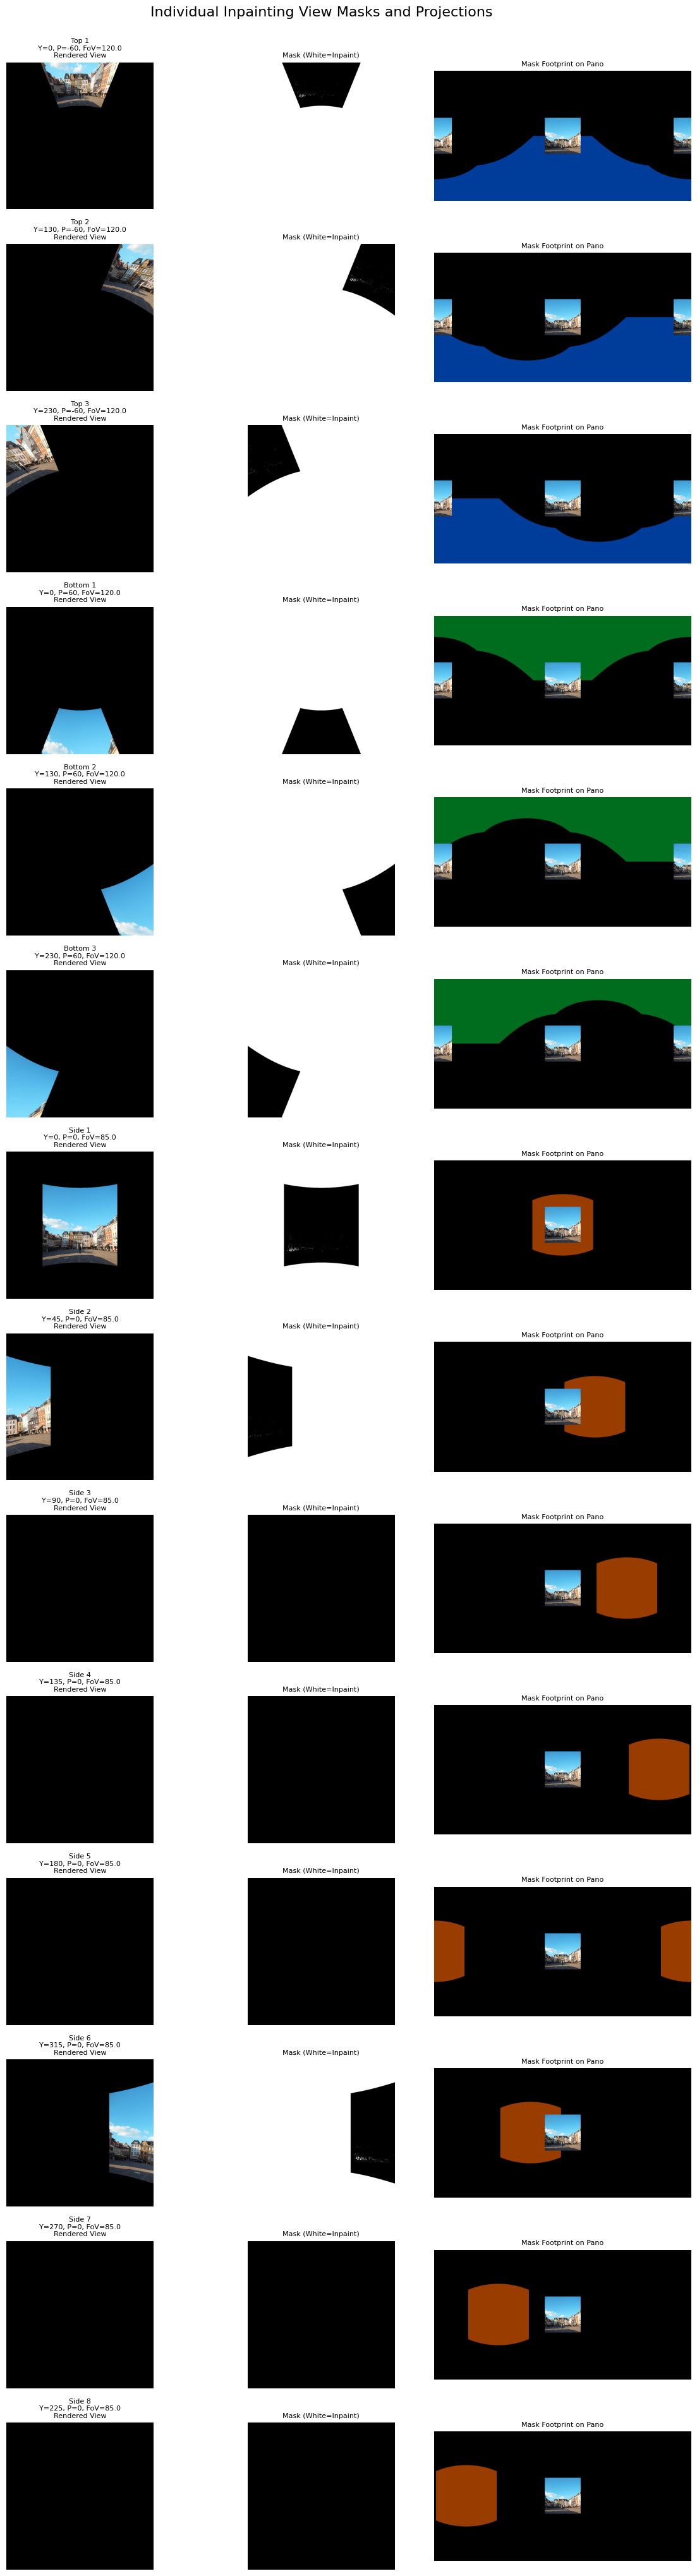

In [3]:
all_views_data = vis_inpaint_strategy()

In [4]:
def load_contolnet_pipeline():
	import sys 
	import torch
	sys.path.append('/home/cedric/PanoramaGenInpaint/FLUX-Controlnet-Inpainting')
	from diffusers.utils import load_image, check_min_version
	from controlnet_flux import FluxControlNetModel
	from transformer_flux import FluxTransformer2DModel
	from pipeline_flux_controlnet_inpaint import FluxControlNetInpaintingPipeline
	from torchao.quantization import quantize_, int8_weight_only

	controlnet = FluxControlNetModel.from_pretrained("alimama-creative/FLUX.1-dev-Controlnet-Inpainting-Alpha", torch_dtype=torch.bfloat16)
	transformer = FluxTransformer2DModel.from_pretrained(
			"black-forest-labs/FLUX.1-dev", subfolder='transformer', torch_dtype=torch.bfloat16)
	
	quantize_(transformer, int8_weight_only())
	quantize_(controlnet, int8_weight_only())

	pipe = FluxControlNetInpaintingPipeline.from_pretrained(
		"black-forest-labs/FLUX.1-dev",
		controlnet=controlnet,
		transformer=transformer,
		torch_dtype=torch.bfloat16
	)
	pipe.enable_model_cpu_offload()
	pipe.transformer.to(torch.bfloat16)
	pipe.controlnet.to(torch.bfloat16)
	return pipe 

load_contolnet_pipeline()

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

You set `add_prefix_space`. The tokenizer needs to be converted from the slow tokenizers


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

FluxControlNetInpaintingPipeline {
  "_class_name": "FluxControlNetInpaintingPipeline",
  "_diffusers_version": "0.30.2",
  "_name_or_path": "black-forest-labs/FLUX.1-dev",
  "controlnet": [
    "controlnet_flux",
    "FluxControlNetModel"
  ],
  "scheduler": [
    "diffusers",
    "FlowMatchEulerDiscreteScheduler"
  ],
  "text_encoder": [
    "transformers",
    "CLIPTextModel"
  ],
  "text_encoder_2": [
    "transformers",
    "T5EncoderModel"
  ],
  "tokenizer": [
    "transformers",
    "CLIPTokenizer"
  ],
  "tokenizer_2": [
    "transformers",
    "T5TokenizerFast"
  ],
  "transformer": [
    "transformer_flux",
    "FluxTransformer2DModel"
  ],
  "vae": [
    "diffusers",
    "AutoencoderKL"
  ]
}

## Approach C)  

In [5]:
def fix_inpaint_mask(mask, contour_color=(0, 255, 0), fill_color=(0, 0, 0),extend_amount=100,add_boarder_mode=None):
    mask_copy = mask.copy()
    if mask_copy.dtype != np.uint8:
    
        mask_copy = (mask_copy * 255).astype(np.uint8)
    
    
    inverted = cv2.bitwise_not(mask_copy)
    contours, _ = cv2.findContours(inverted, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    cv2.drawContours(mask_copy, contours, -1, 0 , -1)
    # Now extend the mask into black regions
    if extend_amount > 0:
        kernel = np.ones((extend_amount, extend_amount), np.uint8)
        mask_copy = cv2.dilate(mask_copy, kernel, iterations=1)
        
    blur_amount = 20
    if blur_amount > 0:
        mask_copy = cv2.GaussianBlur(mask_copy, (blur_amount*2+1, blur_amount*2+1), 0)
        # Normalize back to proper range
    return mask_copy

## Perform iterative Inpainting (First Top and Bottom views)

GPU memory cleared


Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

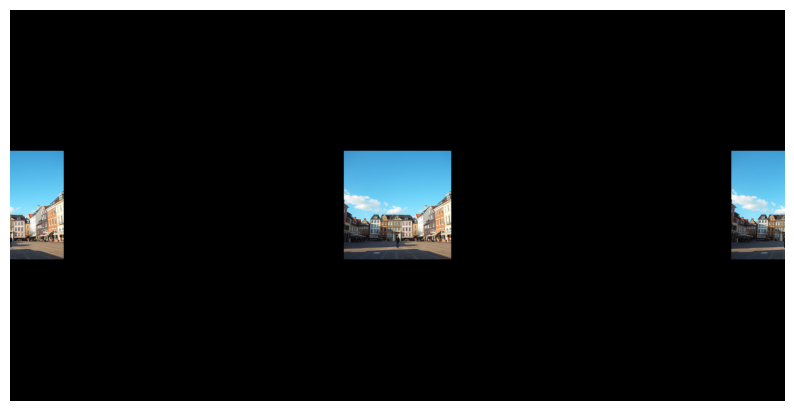

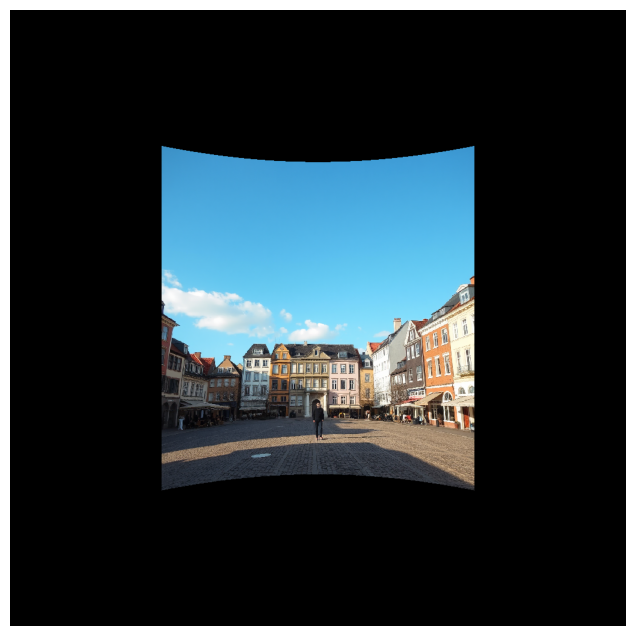

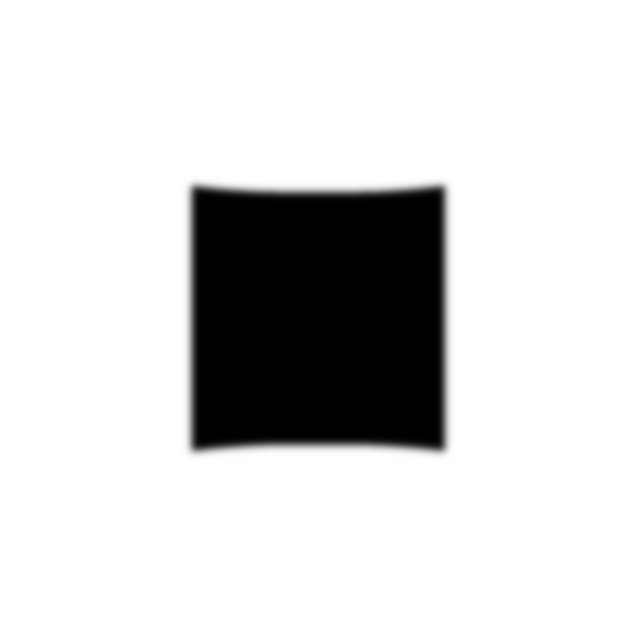

Render image shape: (1024, 1024)(1024, 1024)
Check inputs
Start denoise


  0%|          | 0/30 [00:00<?, ?it/s]

Inpainting done


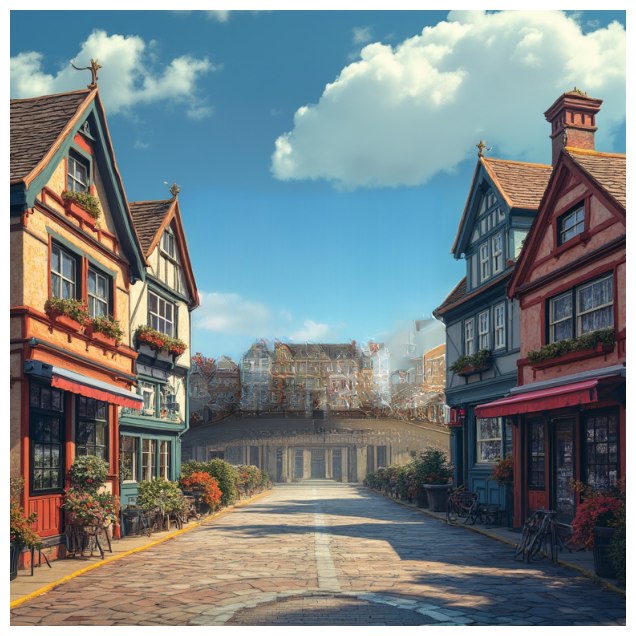

GPU memory cleared
GPU memory cleared


  0%|          | 0/15 [00:13<?, ?it/s]


Error during image refinement: CUDA out of memory. Tried to allocate 48.00 MiB. GPU 0 has a total capacity of 23.52 GiB of which 44.75 MiB is free. Process 35633 has 488.00 MiB memory in use. Including non-PyTorch memory, this process has 22.92 GiB memory in use. Of the allocated memory 22.45 GiB is allocated by PyTorch, and 15.57 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


FileNotFoundError: [Errno 2] No such file or directory: 'refined_output.png'

: 

In [ ]:
top_and_bottom_views = [all_views_data[0],all_views_data[3]]
side_views = all_views_data[6:]
clear_gpu_memory()

USE_CONTROLNET = True
if USE_CONTROLNET:
	pipeline = load_contolnet_pipeline()
else:
	pipeline = load_pipeline()
 
'''
for view in top_and_bottom_views[:2] :
    mask = view['mask']
    mask[mask==255] = 1
    new_mask = fix_inpaint_mask(mask*255)
    #show_image_cv2(new_mask)
    inital_pano = Image.open("initial_pano_with_back.png")
    initial_pano_np = np.array(inital_pano)
    render_img = cv2.cvtColor(view['render'], cv2.COLOR_BGR2RGB)
    #show_image_cv2(render_img)
    render_img = cv2_to_pil(render_img)

    print(f"Render image shape: {render_img.size}{mask.shape}")
    #image = Image.open('top1.png')
    image = generate_outpaint(pipeline, render_img, new_mask,vis=True,prompt='floor of a city town square')
    final_pano = project_perspective_to_equirect(
        cv2.cvtColor(pil_to_cv2(image),cv2.COLOR_BGR2RGB), 
        initial_pano_np,
        yaw_deg=-view['yaw'], 
        pitch_deg=view['pitch'],
        h_fov_deg=view['fov'], 
        v_fov_deg=view['fov'],
        mask=mask  # Original mask - only project where we outpainted
    )

    # Visualize the updated panorama
    plt.figure(figsize=(20, 10))
    plt.imshow(final_pano)
    plt.title(f"Panorama after outpainting {view['label']}")
    plt.axis('off')
    plt.show()
    #break
'''


inital_pano = Image.open("imgs/initial_pano_with_back.png")
initial_pano_np = np.array(inital_pano)
output_size = 1024
'''
for view in top_and_bottom_views :
    show_image_cv2(cv2.cvtColor(initial_pano_np, cv2.COLOR_BGR2RGB))
    render_img = render_perspective(
                initial_pano_np, view['yaw'], -view['pitch'], view['fov'], view['vfov'], output_size
    )
    
    mask = create_mask_from_black(render_img, threshold=10)
    
    mask[mask==255] = 1
    new_mask = fix_inpaint_mask(mask*255)
    
    render_img = cv2.cvtColor(render_img, cv2.COLOR_BGR2RGB)
    #show_image_cv2(render_img)
    render_img = cv2_to_pil(render_img)
    if view['label'] == 'Top' : 
        prompt = 'Floor of a city town square'      
    else : 
        prompt = 'Sky of a city town square, no buildings'
    
    
	
    print(f"Render image shape: {render_img.size}{mask.shape}")
    #image = Image.open('top1.png')
    image = generate_outpaint(pipeline, render_img, new_mask,vis=True,prompt=prompt)
    image.save("outpainted_test.png")
    #image = Image.open("outpainted_test.png")
    initial_pano_np = project_perspective_to_equirect(
        cv2.cvtColor(pil_to_cv2(image),cv2.COLOR_BGR2RGB), 
        initial_pano_np,
        yaw_deg=view['yaw'], 
        pitch_deg=view['pitch'],
        h_fov_deg=view['fov'], 
        v_fov_deg=view['fov'],
        mask=None,  # Original mask - only project where we outpainted
        mirror=False
    )

    # Visualize the updated panorama
    plt.figure(figsize=(20, 10))
    plt.imshow(initial_pano_np)
    plt.title(f"Panorama after outpainting {view['label']}")
    plt.axis('off')
    plt.show()
    #break
'''
side_view_pano = Image.open("imgs/initial_pano_center.png")
side_view_pano_np = np.array(side_view_pano)
for idx,view in enumerate(side_views[:2]):
    show_image_cv2(cv2.cvtColor(initial_pano_np, cv2.COLOR_BGR2RGB))
    render_img = render_perspective(
                side_view_pano_np, view['yaw'], -view['pitch'], view['fov'], view['vfov'], output_size
    )
    show_image_cv2(cv2.cvtColor(render_img, cv2.COLOR_BGR2RGB))
    
    mask = create_mask_from_black(render_img, threshold=10)
    new_mask = fix_inpaint_mask(mask,extend_amount=100)
    new_mask = Image.fromarray(new_mask).convert("L")
    new_mask.save(f"new_mask_{idx}.png")
    render_img = Image.fromarray(render_img).convert("RGB")

    show_image_cv2(pil_to_cv2(new_mask))
    
    prompt = 'a different house on a market square'      
    
    print(f"Render image shape: {render_img.size}{mask.shape}")
    #image = Image.open('top1.png')
    image = outpaint_controlnet(pipeline, render_img, new_mask,vis=True,prompt=prompt,num_steps=30,guidance_scale=3.5,cond_scale=0.4)
    image = image.resize((1024, 1024), Image.LANCZOS)
    image.save(f"imgs/render.png")
    clear_gpu_memory()
    run_with_conda_env('diffusers33', 'refiner.py imgs/render.png')
    image = Image.open("refined_output.png")
    

    new_mask = np.array(new_mask)
    #image = generate_outpaint(pipeline, image, np.ones_like(new_mask),vis=True,num_steps=20,prompt=prompt)
    #image = Image.open("outpainted_test.png")
    cur_mask = new_mask 
    initial_pano_np = project_perspective_to_equirect(
        cv2.cvtColor(pil_to_cv2(image),cv2.COLOR_BGR2RGB), 
        initial_pano_np,
        yaw_deg=view['yaw'], 
        pitch_deg=view['pitch'],
        h_fov_deg=view['fov'], 
        v_fov_deg=view['fov'],
        mask=new_mask,  # Original mask - only project where we outpainted,
        mirror=False
    )
    
    side_view_pano_np = project_perspective_to_equirect(
        cv2.cvtColor(pil_to_cv2(image),cv2.COLOR_BGR2RGB), 
        side_view_pano_np,
        yaw_deg=view['yaw'], 
        pitch_deg=view['pitch'],
        h_fov_deg=view['fov'], 
        v_fov_deg=view['fov'],
        mask=new_mask,  # Original mask - only project where we outpainted,
        mirror=False
    )

    # Visualize the updated panorama
    plt.figure(figsize=(20, 10))
    plt.imshow(initial_pano_np)
    plt.title(f"Panorama after outpainting {view['label']}")
    plt.axis('off')
    plt.show()

'''
for idx,view in enumerate(side_views) : 
    mask = view['mask']
    mask[mask==255] = 1
    #mask = cv2.resize(mask, (IMAGE_SIZE, IMAGE_SIZE))
    render_img = cv2.cvtColor(view['render'], cv2.COLOR_BGR2RGB)
    show_image_cv2(render_img)
    render_img = cv2_to_pil(render_img)
    
    print(f"Render image shape: {render_img.size}{mask.shape}")
    image = generate_outpaint(pipeline, render_img, mask,vis=True)
    if idx == 1 : 
    	break
'''